In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance, ks_2samp

import matplotlib.pyplot as plt

def view_single_distribution(
    df,
    metric="area",
    bins=50,
    density=True,
    ax=None,
    title_prefix=""
):
    """
    View a histogram of a single metric from a DataFrame containing
    columns like: ['video', 'frame', 'area', 'eccentricity', 'solidity', 'perimeter'].

    Args:
        df (pd.DataFrame): The input DataFrame.
        metric (str): Which column to visualize, e.g. 'area', 'eccentricity', 'solidity', 'perimeter'.
        bins (int): Number of histogram bins.
        density (bool): Whether to normalize the histogram (density=True) or show counts (density=False).
        ax (matplotlib.axes.Axes, optional): Matplotlib Axes to plot on. 
            If None, a new figure/axes is created.
        title_prefix (str, optional): An optional prefix added to the plot title (e.g. "Real" or "Generated").

    Returns:
        matplotlib.axes.Axes: The axes on which the histogram was plotted.
    """
    if metric not in df.columns:
        raise ValueError(
            f"Metric '{metric}' not found in DataFrame columns. "
            f"Available columns: {df.columns.tolist()}"
        )

    # Drop any NaN or invalid values
    values = df[metric].dropna()

    # Create new figure/axes if none provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Plot histogram
    ax.hist(values, bins=bins, alpha=0.7, edgecolor="black", density=density)
    ax.set_title(f"{title_prefix} {metric.capitalize()} Distribution")
    ax.set_xlabel(metric)
    ax.set_ylabel("Density" if density else "Count")

    return ax

def compare_distributions_wasserstein(df_real, df_gen, metric):
    """Compute Wasserstein distance for the given metric."""
    real_values = df_real[metric].dropna()
    gen_values  = df_gen[metric].dropna()
    return wasserstein_distance(real_values, gen_values)

def compare_distributions_ks(df_real, df_gen, metric):
    """Compute KS statistic for the given metric."""
    real_values = df_real[metric].dropna()
    gen_values  = df_gen[metric].dropna()
    ks_stat, ks_pval = ks_2samp(real_values, gen_values)
    return ks_stat, ks_pval

def plot_overlaid_histograms(df_real, df_gen, metric, ax, bins=50):
    """Plot two overlaid histograms for the given metric."""
    real_values = df_real[metric].dropna()
    gen_values  = df_gen[metric].dropna()
    ax.hist(real_values, bins=bins, alpha=0.5, label="Real", density=True)
    ax.hist(gen_values,  bins=bins, alpha=0.5, label="Generated", density=True)
    ax.set_xlabel(metric)
    ax.set_ylabel("Density")
    ax.legend()

In [2]:
############################################################
# 1) LOAD PROLIFERATION DATAFRAMES
############################################################
dfs_prolif = {
    "real": pd.read_csv("../results/checkpoint-900-val-old/proliferation_metrics.csv"),
    "baseline": pd.read_csv("../results/i2v_baseline/proliferation_metrics.csv"),
    "r64_250": pd.read_csv("../results/i2v_r64_250/proliferation_metrics.csv"),
    "r64_500": pd.read_csv("../results/i2v_r64_500/proliferation_metrics.csv"),
    "r64_750": pd.read_csv("../results/i2v_r64_750/proliferation_metrics.csv"),
    "r64_900": pd.read_csv("../results/i2v_r64_900/proliferation_metrics.csv"),
    "r128_250": pd.read_csv("../results/i2v_r128_250/proliferation_metrics.csv"),
    "r128_500": pd.read_csv("../results/i2v_r128_500/proliferation_metrics.csv"),
    "r128_750": pd.read_csv("../results/i2v_r128_750/proliferation_metrics.csv"),
    "r128_900": pd.read_csv("../results/i2v_r128_900/proliferation_metrics.csv"),
    "r256_250": pd.read_csv("../results/i2v_r256_250/proliferation_metrics.csv"),
    "r256_375": pd.read_csv("../results/i2v_r256_375/proliferation_metrics.csv"),
    "r256_750": pd.read_csv("../results/i2v_r256_750/proliferation_metrics.csv"),
    "r256_900": pd.read_csv("../results/i2v_r256_900/proliferation_metrics.csv"),
}

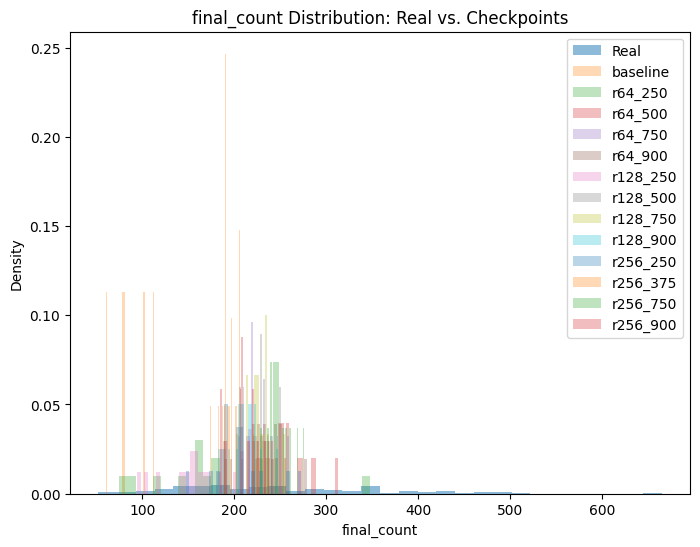

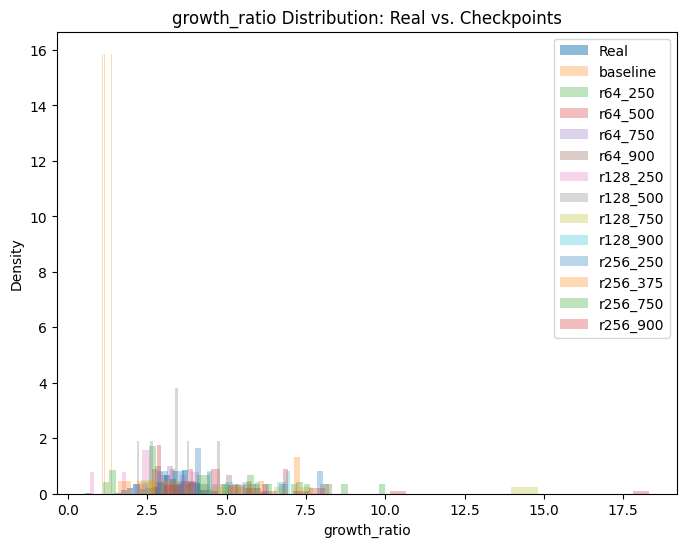

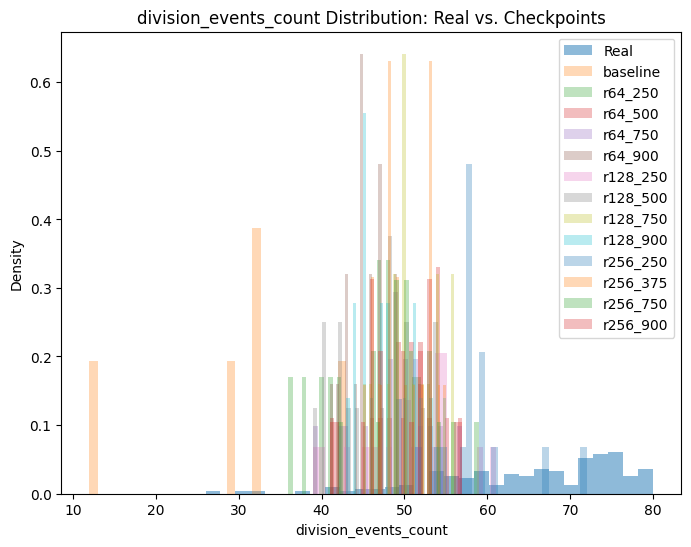

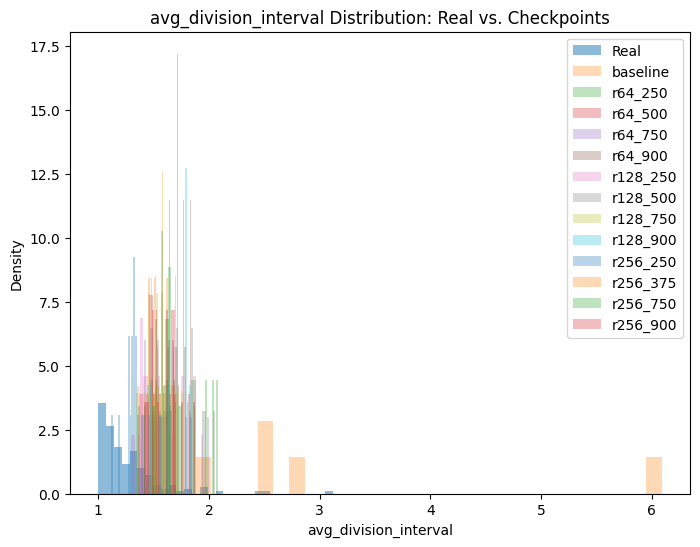

In [6]:
# List of columns in proliferation_metrics.csv that we want to compare
prolif_metrics = [
    "final_count",
    "growth_ratio",
    "division_events_count",
    "avg_division_interval"
]

############################################################
# 2) PLOT OVERLAID HISTOGRAMS FOR EACH PROLIFERATION METRIC
############################################################
import matplotlib.pyplot as plt

for metric in prolif_metrics:
    plt.figure(figsize=(8,6))
    # Plot real distribution
    real_vals = dfs_prolif["real"][metric].dropna()
    plt.hist(real_vals, bins=30, alpha=0.5, density=True, label="Real")

    # Plot each checkpoint overlay
    for name, df in dfs_prolif.items():
        if name == "real":
            continue
        gen_vals = df[metric].dropna()
        plt.hist(gen_vals, bins=30, alpha=0.3, density=True, label=name)

    plt.title(f"{metric} Distribution: Real vs. Checkpoints")
    plt.xlabel(metric)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

In [8]:
############################################################
# 3) COMPUTE DISTRIBUTION DISTANCES (E.G. WASSERSTEIN, KS)
############################################################
from scipy.stats import wasserstein_distance, ks_2samp
results = []

for checkpoint_name, df_gen in dfs_prolif.items():
    if checkpoint_name == "real":
        continue  # skip comparing real with itself
    for metric in prolif_metrics:
        real_vals = dfs_prolif["real"][metric].dropna()
        gen_vals  = df_gen[metric].dropna()
        
        if len(real_vals) == 0 or len(gen_vals) == 0:
            # If no data, skip
            continue

        # Compute Wasserstein and KS
        wdist  = wasserstein_distance(real_vals, gen_vals)
        ks_stat, ks_pval = ks_2samp(real_vals, gen_vals)

        results.append({
            "checkpoint": checkpoint_name,
            "metric": metric,
            "wasserstein_distance": wdist,
            "ks_stat": ks_stat,
            "ks_pval": ks_pval
        })

df_prolif_results = pd.DataFrame(results)
df_prolif_results

############################################################
# 4) RANK CHECKPOINTS BY AVERAGE DISTANCE TO REAL
############################################################
mean_dists = (
    df_prolif_results
    .groupby("checkpoint")["wasserstein_distance"]
    .mean()   # average across the 6 proliferation metrics
    .sort_values()
)
print("Average Wasserstein distance on proliferation metrics:")
print(mean_dists)

Average Wasserstein distance on proliferation metrics:
checkpoint
r256_250    21.317175
r64_500     22.690436
r64_900     24.037272
r128_500    24.295283
r64_750     24.324121
r256_900    24.482944
r128_900    25.177387
r128_750    25.252649
r256_750    25.256230
r128_250    26.005547
r256_375    26.807008
r64_250     28.387133
baseline    51.439230
Name: wasserstein_distance, dtype: float64


In [10]:
prolif_metrics = [
    "final_count",
    "growth_ratio",
    "division_events_count",
    "avg_division_interval"
]

for metric in prolif_metrics:
    # Filter rows for this metric
    subdf = df_prolif_results[df_prolif_results["metric"] == metric].copy()
    
    # Sort by wasserstein_distance ascending (lowest distance = best)
    subdf = subdf.sort_values("wasserstein_distance")
    
    print(f"\n=== Ranking for '{metric}' by Wasserstein Distance ===")
    display(subdf[["checkpoint", "metric", "wasserstein_distance"]])


=== Ranking for 'final_count' by Wasserstein Distance ===


,checkpoint,metric,wasserstein_distance
16,r64_900,final_count,74.226402
8,r64_500,final_count,74.759918
36,r256_250,final_count,75.396573
24,r128_500,final_count,77.154070
48,r256_900,final_count,78.258398
12,r64_750,final_count,79.142955
32,r128_900,final_count,80.480620
28,r128_750,final_count,81.754446
44,r256_750,final_count,82.242818
20,r128_250,final_count,88.082558



=== Ranking for 'growth_ratio' by Wasserstein Distance ===


,checkpoint,metric,wasserstein_distance
25,r128_500,growth_ratio,0.254646
21,r128_250,growth_ratio,0.572506
9,r64_500,growth_ratio,0.754729
37,r256_250,growth_ratio,0.932749
5,r64_250,growth_ratio,0.983912
13,r64_750,growth_ratio,0.995658
41,r256_375,growth_ratio,1.295289
17,r64_900,growth_ratio,1.381450
33,r128_900,growth_ratio,1.666081
1,baseline,growth_ratio,2.109388



=== Ranking for 'division_events_count' by Wasserstein Distance ===


,checkpoint,metric,wasserstein_distance
38,r256_250,division_events_count,8.772950
10,r64_500,division_events_count,14.932969
22,r128_250,division_events_count,15.054651
30,r128_750,division_events_count,15.481532
46,r256_750,division_events_count,15.484952
42,r256_375,division_events_count,16.186047
50,r256_900,division_events_count,16.419897
14,r64_750,division_events_count,16.781122
34,r128_900,division_events_count,18.138243
26,r128_500,division_events_count,19.292151



=== Ranking for 'avg_division_interval' by Wasserstein Distance ===


,checkpoint,metric,wasserstein_distance
39,r256_250,avg_division_interval,0.166430
23,r128_250,avg_division_interval,0.312471
11,r64_500,avg_division_interval,0.314128
31,r128_750,avg_division_interval,0.332671
43,r256_375,avg_division_interval,0.348287
47,r256_750,avg_division_interval,0.363512
15,r64_750,avg_division_interval,0.376751
51,r256_900,avg_division_interval,0.380745
35,r128_900,avg_division_interval,0.424603
27,r128_500,avg_division_interval,0.480263


In [11]:
df_prolif_results

,checkpoint,metric,wasserstein_distance,ks_stat,ks_pval
0,baseline,final_count,166.062791,0.936047,6.388142e-06
1,baseline,growth_ratio,2.109388,0.994186,8.774920e-09
2,baseline,division_events_count,35.679070,0.953488,1.882220e-06
3,baseline,avg_division_interval,1.905674,0.959302,1.158289e-06
4,r64_250,final_count,91.095137,0.589323,6.317305e-04
5,r64_250,growth_ratio,0.983912,0.510042,5.226251e-03
6,r64_250,division_events_count,20.942918,0.889535,7.692673e-10
7,r64_250,avg_division_interval,0.526566,0.860465,5.961841e-09
8,r64_500,final_count,74.759918,0.465116,1.376240e-03
9,r64_500,growth_ratio,0.754729,0.351744,2.390738e-01
